# **Measuring Bias in multiclass classification**


This tutorial will explain how to measure bias in a multiclass classification task using the holisticai library. We will introduce here some of the functions that can help study algorithmic bias.

The sections are organised as follows :
1. Load the data : we load the student dataset as a pandas DataFrame
2. Data Exploration : some preliminary analysis of the data
3. Train a Model : we train a model (sklearn)
4. Measure Bias : we compute a few bias metrics, and comment on their meaning

## **Load the data**

First of all, we need to import the required packages to perform our bias analysis and mitigation. You will need to have the `holisticai` package installed on your system, remember that you can install it by running: 
```bash
!pip install holisticai[all]
```

In [1]:
# Imports
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

The student dataset can be easily

In [2]:
from holisticai.datasets import load_dataset

dataset = load_dataset('student_multiclass')
dataset

Dataset({
        features: ['X', 'y', 'p_attr'],
        num_rows: 395
    })

## **Data Exploration**

In [3]:
dataset['p_attr']

0      'F'
1      'F'
2      'F'
3      'F'
4      'F'
      ... 
390    'M'
391    'M'
392    'M'
393    'M'
394    'M'
Name: p_attr, Length: 395, dtype: object

<Axes: title={'center': 'Frequency matrix plot'}, xlabel='Class', ylabel='Group'>

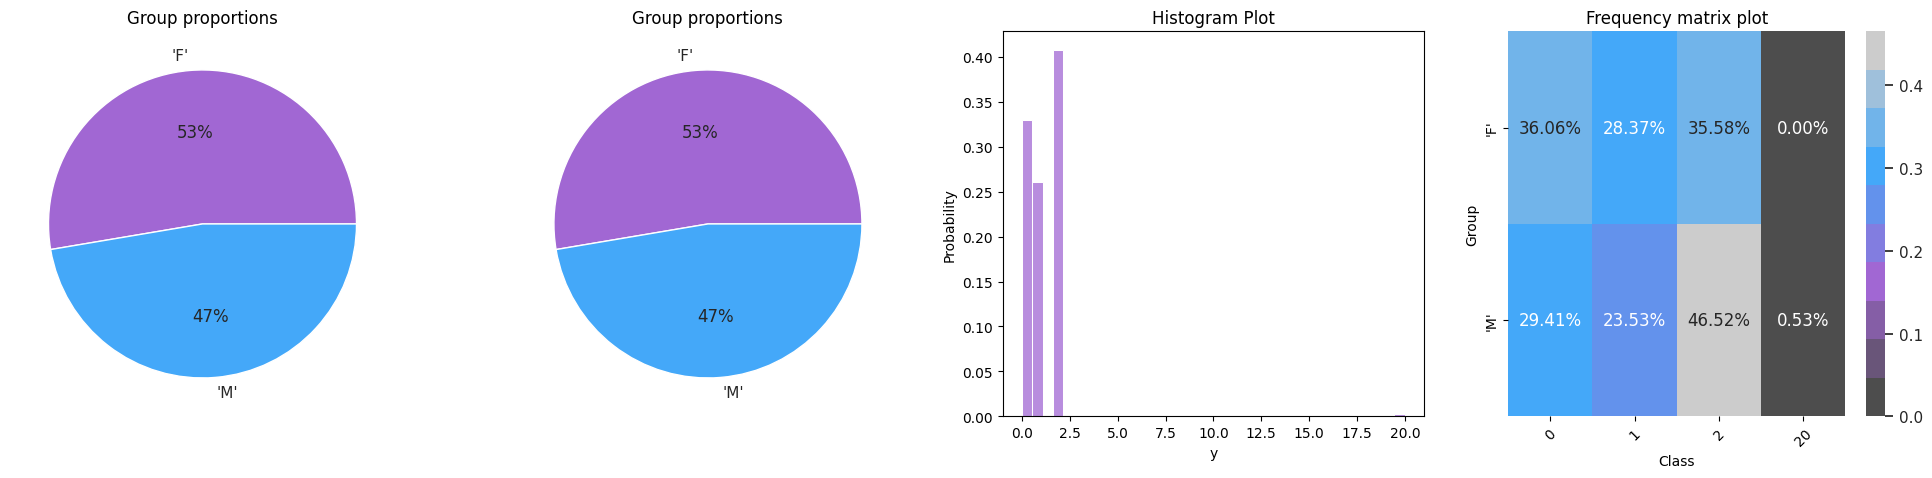

In [4]:
from holisticai.plots.bias import group_pie_plot
from holisticai.plots.bias import histogram_plot
from holisticai.plots.bias import frequency_matrix_plot
from holisticai.plots.bias import frequency_plot
import matplotlib.pyplot as plt

fig,axs = plt.subplots(1,4, figsize=(25,5))
group_pie_plot(dataset['p_attr'], ax=axs[0])
group_pie_plot(dataset['p_attr'], ax=axs[1])
histogram_plot(dataset['y'], ax=axs[2])
frequency_matrix_plot(dataset['p_attr'], dataset['y'], normalize='group', ax=axs[3])

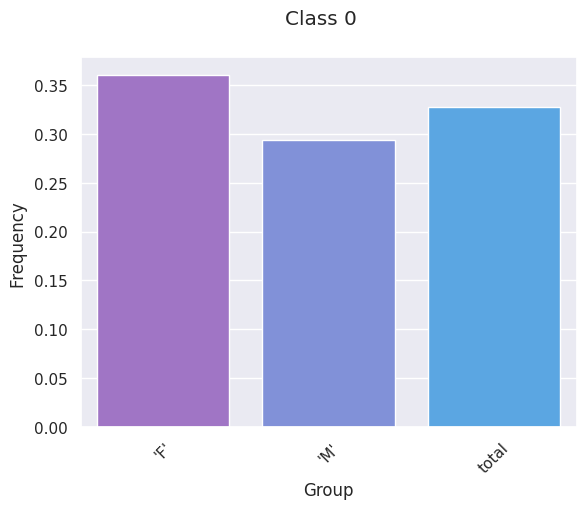

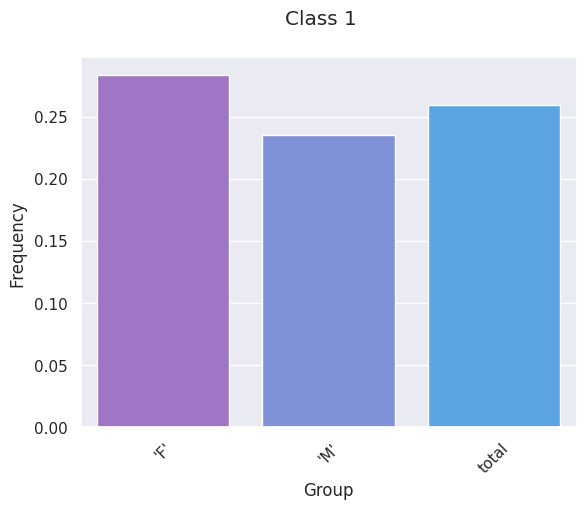

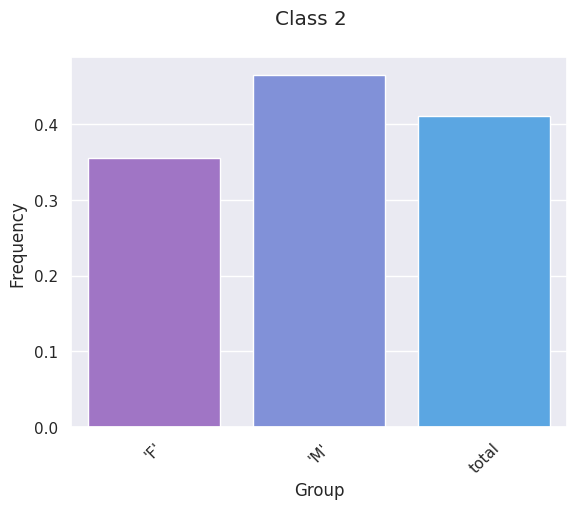

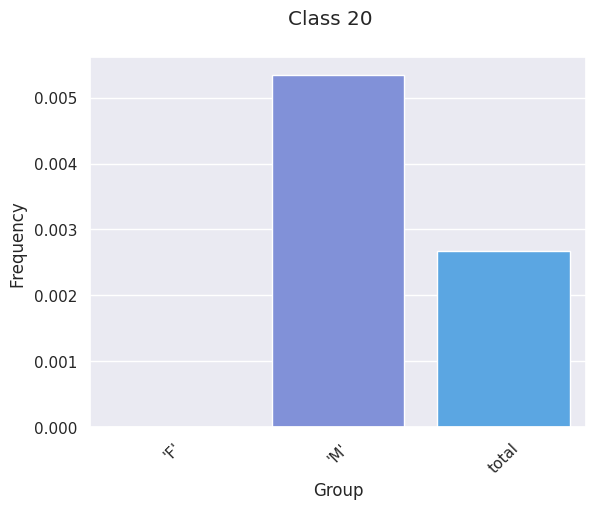

In [5]:
frequency_plot(dataset['p_attr'], dataset['y'])

## **Train a model**


In [6]:
datasets = dataset.train_test_split(test_size=0.3)
datasets

DatasetDict({
    train: Dataset({
        features: ['X', 'y', 'p_attr'],
        num_rows: 276
    }),
    test: Dataset({
        features: ['X', 'y', 'p_attr'],
        num_rows: 119
    })
})

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Train a simple Random Forest Classifier
x_train = datasets['train']['X']
y_train = datasets['train']['y']

model = RandomForestClassifier(random_state=111)
model.fit(x_train, y_train)

# Predict values
x_test = datasets['test']['X']
y_test = datasets['test']['y']
p_attr_test = datasets['test']['p_attr']
y_pred = model.predict(x_test)

In [11]:
from holisticai.metrics.bias import confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [12]:
confusion_matrix(y_pred, y_test)

,0,1,2
0,20.0,11.0,16.0
1,5.0,8.0,9.0
2,8.0,14.0,28.0


In [13]:
# evaluate
print (accuracy_score(y_test, y_pred))
print (precision_score(y_test, y_pred, average=None))
print (recall_score(y_test, y_pred, average=None))

0.47058823529411764
[0.42553191 0.36363636 0.56      ]
[0.60606061 0.24242424 0.52830189]


## **Measure bias**

In [14]:
from holisticai.plots.bias import frequency_matrix_plot
from holisticai.plots.bias import frequency_plot

In [15]:
y_pred = model.predict(x_test)   # multiclass prediction vector                                                 # multiclass label vector

<Axes: title={'center': 'Frequency matrix plot'}, xlabel='Class', ylabel='Group'>

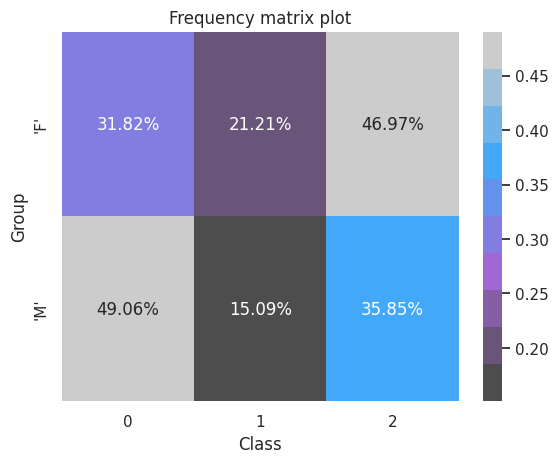

In [16]:
frequency_matrix_plot(p_attr_test, y_pred, normalize='group')

Using the above plot, we observe unfairness by looking at differences over columns. For instance we look at the class 1.0, and observe how the 'health' group has a much higher probability of being within it.

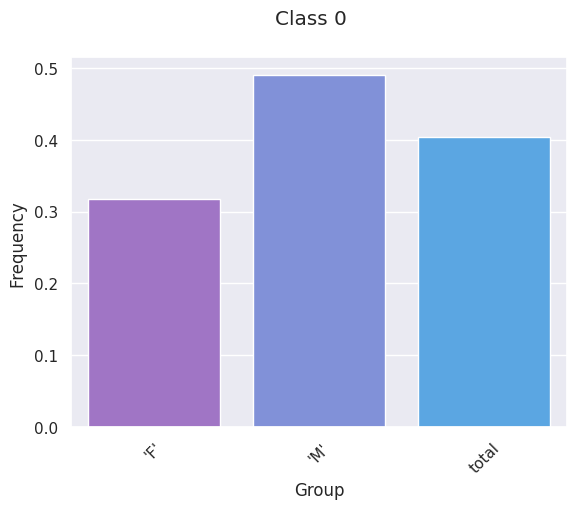

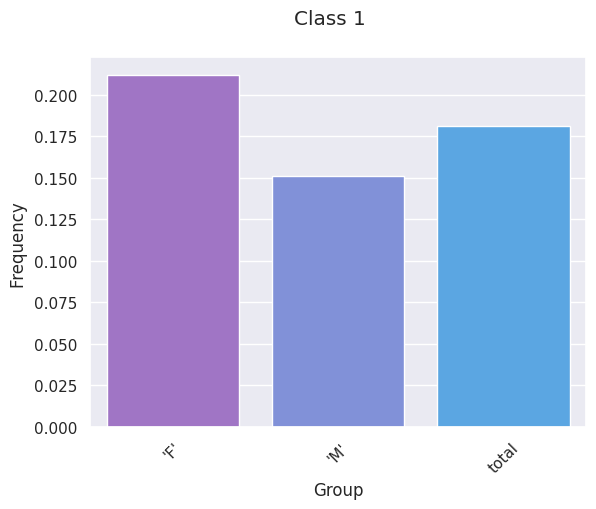

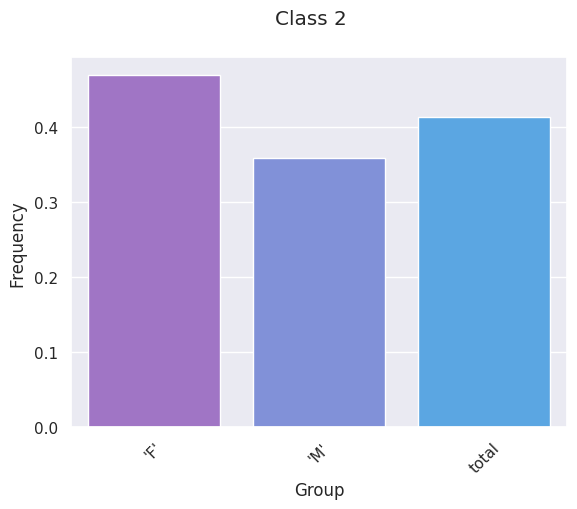

In [17]:
frequency_plot(p_attr_test, y_pred)

This is the same data as the previous plot, but displayed in a different way.

Let's compute a few bias metrics. We have generalised versions of '1d' bias metrics. For instance multiclass statistical parity.

In [18]:
from holisticai.metrics.bias import multiclass_statistical_parity

multiclass_statistical_parity(
    p_attr_test, y_pred, groups=None, classes=None, aggregation_fun="mean"
)

0.1723842195540309

We now compute statistical parity, generalized for the multiclass case. We aggregate by taking the average multilabel statistical parity over all possible group pairs (`aggregation_fun="mean"`). As in the 1d case, the suggested accepted range is (-0.1, 0.1).

In [19]:
multiclass_statistical_parity(
    p_attr_test, y_pred, groups=None, classes=None, aggregation_fun="max"
)

0.1723842195540309

Alternatively, we could aggregate by taking the maximum (`aggregation_fun="max"`) over all possible group pairs. As expected, the maximum statistical parity is higher in this case.

We can try another bias metric, for instace multiclass_equality_of_opp is the multidimensional version of the 1d equal opportunity metric.

In [20]:
from holisticai.metrics.bias import multiclass_equality_of_opp

multiclass_equality_of_opp(
    p_attr_test, y_pred, y_test, groups=None, classes=None, aggregation_fun="mean"
)

0.22930443094916778

In [21]:
multiclass_equality_of_opp(
    p_attr_test, y_pred, y_test, groups=None, classes=None, aggregation_fun="max"
)

0.22930443094916778

In [22]:
from holisticai.metrics.bias import multiclass_bias_metrics
multiclass_bias_metrics(p_attr_test, y_pred, y_test, metric_type='both')

,Value,Reference
Metric,,
Max Multiclass Statistical Parity,0.172384,0
Mean Multiclass Statistical Parity,0.172384,0
Max Multiclass Equality of Opportunity,0.229304,0
Max Multiclass Average Odds,0.147369,0
Max Multiclass True Positive Difference,0.195308,0
Mean Multiclass Equality of Opportunity,0.229304,0
Mean Multiclass Average Odds,0.147369,0
Mean Multiclass True Positive Difference,0.195308,0
